In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ydata_profiling as yp
from sklearn.model_selection import train_test_split
import seaborn as sns



In [2]:
data = pd.read_csv('./data/covtype.data', sep=',', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


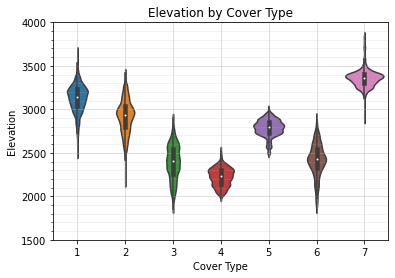

In [3]:
elevation_data = data.iloc[:, 0]
cover_type_data = data.iloc[:, -1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.violinplot(x=cover_type_data, y=elevation_data)

major_ticks = np.arange(1500, 4001, 500)
minor_ticks = np.arange(1500, 4001, 100)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.xlabel('Cover Type')
plt.ylabel('Elevation')
plt.title('Elevation by Cover Type')
plt.savefig('./assets/elevation_by_cover_type.png', facecolor='white')


In [ ]:
#Elevation heuristics

# Cover_type 1: 2900-3300
# Cover_type 2: 2800-3100
# Cover_type 3: 2300-2600
# Cover_type 4: 2000-2300
# Cover_type 5: 2700-2800
# Cover_type 6: 2400-2500
# Cover_type 7: 3300-3500

elevation_ranges = {
    1: (3100, 3300),
    2: (2900, 3100),
    3: (2500, 2700),
    4: (1500, 2300),
    5: (2700, 2900),
    6: (2300, 2500),
    7: (3300, 4000)
}

def get_cover_type(elevation):
    for cover_type, elevation_range in elevation_ranges.items():
        if elevation > elevation_range[0] and elevation < elevation_range[1]:
            return cover_type
    raise ValueError('Elevation out of range')


In [3]:
y = data.iloc[:, -1]

wilderness_areas = data.iloc[:, 10:14]
wilderness_areas.columns = list(range(1, 5))
data['10'] = wilderness_areas.idxmax(axis=1)

soil_types = data.iloc[:, 14:54]
soil_types.columns = list(range(1, 41))
data['11'] = soil_types.idxmax(axis=1)


data = data.drop(columns=data.columns[10:55])
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2596,51,3,258,0,510,221,232,148,6279,1,29
1,2590,56,2,212,-6,390,220,235,151,6225,1,29
2,2804,139,9,268,65,3180,234,238,135,6121,1,12
3,2785,155,18,242,118,3090,238,238,122,6211,1,30
4,2595,45,2,153,-1,391,220,234,150,6172,1,29


In [5]:
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

(464809, 12)
(116203, 12)
(464809,)
(116203,)


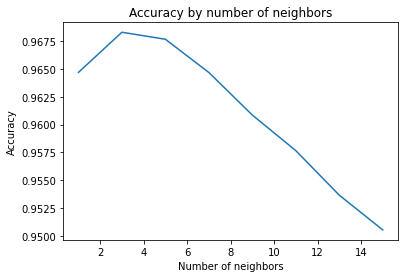

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

neighbors = [1, 3, 5, 7, 9, 11, 13, 15]
accuracy = []

for i in neighbors:
    pipe = Pipeline([('knn', KNeighborsClassifier(n_neighbors=i))])
    pipe.fit(X_train, y_train)
    accuracy.append(pipe.score(X_test, y_test))

plt.plot(neighbors, accuracy)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy by number of neighbors')
plt.savefig(f'./assets/knn_neighbors_test.png', facecolor='white')

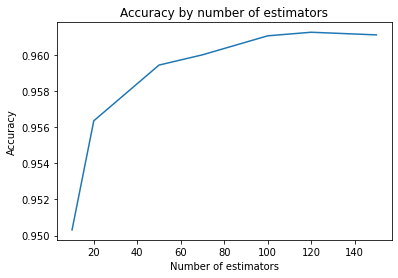

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

estimators = [10, 20, 50, 70, 100, 120, 150]
accuracy = []


for i in estimators:
    pipe = Pipeline([('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=i))])
    pipe.fit(X_train, y_train)
    accuracy.append(pipe.score(X_test, y_test))

plt.plot(estimators, accuracy)
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy by number of estimators')
plt.savefig(f'./assets/rf_estimators.png', facecolor='white')



In [97]:
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(optimizer='adam', activation='relu', dropout_rate=0.2, neurons=64):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def tune_hyperparameters(X_train, y_train, n_iter=10, cv=3):
    model = KerasClassifier(build_fn=create_model, verbose=0)
    params = {
        'neurons': [32, 64, 128],
        'activation': ['relu', 'sigmoid'],
        'dropout_rate': [0.1, 0.2, 0.3],
        'optimizer': ['adam', 'sgd'],
        'epochs': [10, 20, 30, 50]
    }
    search = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter, cv=cv)
    search.fit(X_train, y_train)
    print("Best score: %0.3f" % search.best_score_)
    print("Best parameters:", search.best_params_)
    return search.best_params_

best_params = tune_hyperparameters(X_train, y_train)

model = create_model(**best_params)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'])

# Save training history plot of accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('./assets/model_accuracy.png')

# Save training history plot of loss
plt.figure()
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('./assets/model_loss.png')

# Save model
tf.keras.models.save_model(model, './models/nn.h5')

/tmp/ipykernel_47458/387613610.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


KeyboardInterrupt: 